In [1]:
import pandas as pd

# 0.) Clean the Apple Data to get a quarterly series of EPS.

In [2]:
y=pd.read_csv("AAPL_quarterly_financials.csv")

In [3]:
y.index=y.name

In [4]:
y=pd.DataFrame(y.loc["BasicEPS",:]).iloc[2:,:]

In [5]:
y

,BasicEPS
09/30/2023,1.47
06/30/2023,1.27
03/31/2023,1.53
12/31/2022,1.89
09/30/2022,1.29
...,...
09/30/1986,NaN
06/30/1986,0.002
03/31/1986,0.002
12/31/1985,0.004


In [6]:
y.index=pd.to_datetime(y.index)

In [7]:
y=y.fillna(0.)

In [8]:
y

,BasicEPS
2023-09-30,1.47
2023-06-30,1.27
2023-03-31,1.53
2022-12-31,1.89
2022-09-30,1.29
...,...
1986-09-30,0.0
1986-06-30,0.002
1986-03-31,0.002
1985-12-31,0.004


# 2.) Normalize all the X data

In [9]:
from pytrends.request import TrendReq

In [10]:
# Create pytrends object
pytrends = TrendReq(hl='en-US', tz=360)

# Set up the keywords and the timeframe
keywords = ["Phone", "Apple Layoffs","MacBook","iPad","Apple CEO","Apple Share Price",
            "Recession","Chip Costs","Taylor Swift Tickets","Samsung","Hospital"]  # Add your keywords here
start_date = '2004-01-01'
end_date = '2024-01-01'

# Create an empty DataFrame to store the results
df = pd.DataFrame()

# Iterate through keywords and fetch data
for keyword in keywords:
    pytrends.build_payload([keyword], cat=0, timeframe=f'{start_date} {end_date}', geo='', gprop='')
    interest_over_time_df = pytrends.interest_over_time()
    df[keyword] = interest_over_time_df[keyword]

In [11]:
X = df.resample("Q").mean()
temp = pd.concat([y,X],axis=1).dropna()
y = temp[["BasicEPS"]].copy()
X = temp.iloc[:,1:].copy()

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4.) Run a Lasso with lambda of .5. Plot a bar chart.

In [13]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

In [14]:
lasso=Lasso(alpha=.1)

In [15]:
lasso.fit(X_scaled,y)

Lasso(alpha=0.1)

In [16]:
coefficients=lasso.coef_

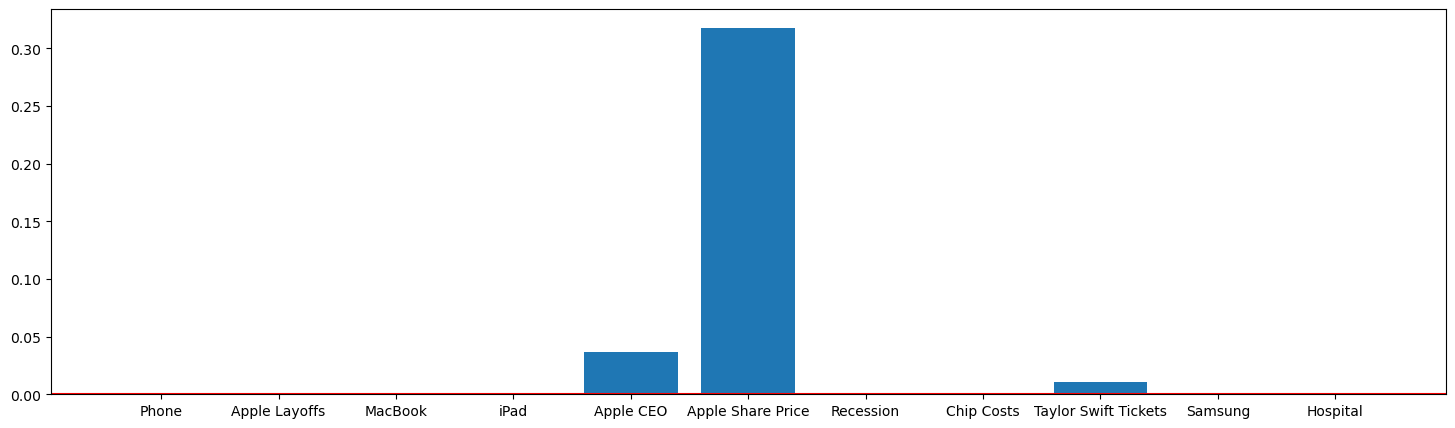

In [17]:
plt.figure(figsize = (18,5))
plt.bar(range(len(coefficients)),coefficients,tick_label=X.columns)
plt.axhline(0.,color = "red")
plt.show()

# 5.) Do these coefficient magnitudes make sense?

The keywords「Apple CEO」and 「Apple Share Price」makes sense as they have positive impact on the sales of Apple devices.However,「Taylor Swift Tickets」may be a little bit confusing.The possible explaination is that 「Taylor Swifts Tickets」 may to some extent reflect people's spare money.

# 6.) Run a for loop looking at 10 different Lambdas and plot the coefficient magnitude for each.

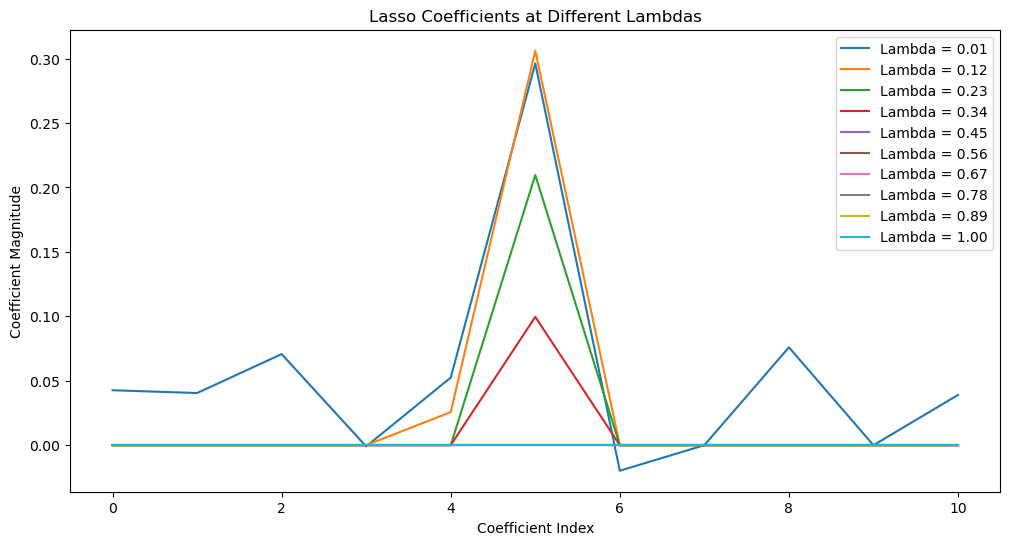

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Setting up different lambda values
lambdas = np.linspace(0.01, 1, 10)  # 10 lambda values from 0.01 to 1

# Initialize an empty list to store coefficients
coef_magnitudes = []

# Looping through each lambda value
for l in lambdas:
    lasso = Lasso(alpha=l)
    lasso.fit(X_scaled, y)
    coef_magnitudes.append(lasso.coef_)

# Plotting the coefficients
plt.figure(figsize=(12, 6))
for i in range(len(coef_magnitudes)):
    plt.plot(coef_magnitudes[i], label=f'Lambda = {lambdas[i]:.2f}')
plt.title('Lasso Coefficients at Different Lambdas')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Magnitude')
plt.legend()
plt.show()


# 7.) Run a cross validation. What is your ideal lambda?

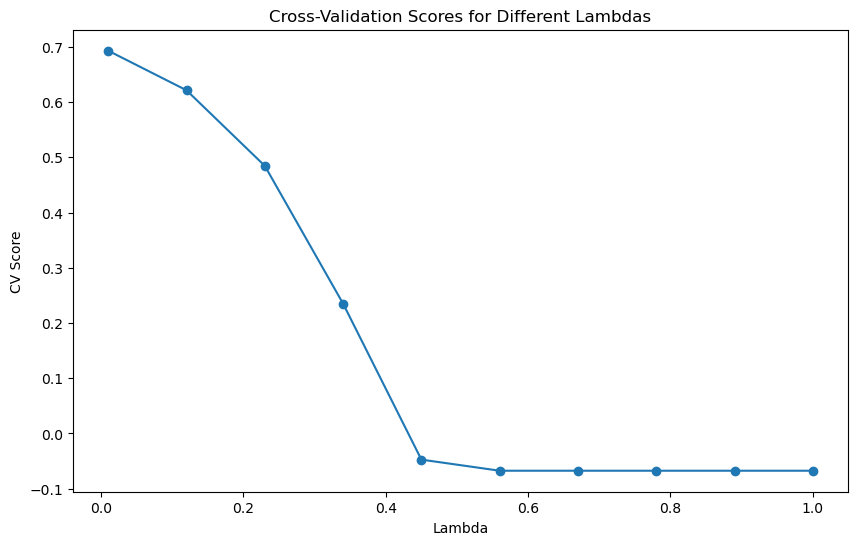

Ideal lambda: 0.01


In [19]:
from sklearn.model_selection import cross_val_score, KFold

# Initialize an empty list to store cross-validation scores
cross_val_scores = []

# Looping through each lambda value for cross-validation
for l in lambdas:
    lasso = Lasso(alpha=l)
    scores = cross_val_score(lasso, X_scaled, y, cv=KFold(5, shuffle=True, random_state=42))
    cross_val_scores.append(np.mean(scores))

# Plotting the cross-validation scores
plt.figure(figsize=(10, 6))
plt.plot(lambdas, cross_val_scores, marker='o')
plt.title('Cross-Validation Scores for Different Lambdas')
plt.xlabel('Lambda')
plt.ylabel('CV Score')
plt.show()

# Identifying the ideal lambda
ideal_lambda = lambdas[np.argmax(cross_val_scores)]
print("Ideal lambda:", ideal_lambda)